In [ ]:
# | default_exp importance_sampling
import jax

jax.config.update("jax_enable_x64", True)

# Importance Sampling for Partially Gaussian State Space Models
> See also the corresponding [section in my thesis](https://stefanheyder.github.io/dissertation/thesis.pdf#nameddest=section.3.6)


After having observed $Y$ one is usually interested in properties of the conditional distribution of states $X$ given $Y$. Typically this means terms of the form

$$
\begin{align*}
\mathbf E (f(X) | Y) &= \mathbf E (f(X_0, \dots, X_n) | Y_0, \dots, Y_n) \\
    &= \int f(x_0, \dots, x_n) p(x_0, \dots, x_n | y_0, \dots, y_n) \mathrm d x_0 \dots \mathrm d x_n.
\end{align*}
$$

As the density $p(x|y)$ is known only up to a constant, we resort to importance sampling with a GLSSM, represented by its gaussian densities $g$. The [Laplace approximation](30_laplace_approximation.ipynb) and [(modified) efficient importance sampling](50_modified_efficient_importance_sampling.ipynb) perform this task for loc concave state space models where the states are jointly gaussian. 

Both methods construct surrogate [linear gaussian state space models](00_glssm.ipynb) that are parameterized by synthetic observations $z_t$ and their covariance matrices $\Omega_t$. Usually $\Omega_t$ is a diagonal matrix which is justified if the components of the observation vector at time $t$, $Y^i_t$, $i = 1, \dots, p$ are conditionally independent given states $X_t$.

These models are then based on the following SSM:
$$
\begin{align*}
    X_0 &\sim \mathcal N (x_0, \Sigma_0) &&\\
    X_{t + 1} &= A_t X_{t} + \varepsilon_{t + 1} &&t = 0, \dots, n - 1\\
    \varepsilon_t &\sim \mathcal N (0, \Sigma_t) && t = 1, \dots, n \\
    S_t &= B_t X_t &&\\
    Z_t &= S_t + \eta_t && t =0, \dots, n & \\
    \eta_t &\sim \mathcal N(0, \Omega_t) && t=0, \dots, n.
\end{align*}
$$

In this setting we can transform the expectation w.r.t the condtiional density $p(x|y)$ to one w.r.t the density $g(x|z)$.

$$
\begin{align*}
\int f(x) p(x|y) \mathrm d x &= \int f(x) \frac{p(x|y)}{g(x|z)} g(x|z) \mathrm d x\\
&= \int f(x) \frac{p(y|x)}{g(z|x)} \frac{g(z)}{p(y)} g(x|z) \mathrm d x.
\end{align*}
$$

Let $w(x) = \frac{p(y|x)}{g(z|x)} = \frac{p(y|s)}{g(z|s)}$ be the (unnormalized) importance sampling weights which only depend on $s_t = B_t x_t$, $t = 0, \dots, n$.

In [ ]:
# | export
from tensorflow_probability.substrates.jax.distributions import (
    MultivariateNormalFullCovariance as MVN,
    MultivariateNormalDiag as MVN_diag,
)
import jax.numpy as jnp
from jaxtyping import Float, Array
from jax import vmap
from functools import partial
from isssm.typing import PGSSM


def log_weights_t(
    s_t: Float[Array, "p"],  # signal
    y_t: Float[Array, "p"],  # observation
    xi_t: Float[Array, "p"],  # parameters
    dist,  # observation distribution
    z_t: Float[Array, "p"],  # synthetic observation
    Omega_t: Float[Array, "p p"],  # synthetic observation covariance, assumed diagonal
) -> Float:  # single log weight
    """Log weight for a single time point."""
    p_ys = dist(s_t, xi_t).log_prob(y_t).sum()

    omega_t = jnp.sqrt(jnp.diag(Omega_t))
    g_zs = MVN_diag(s_t, omega_t).log_prob(z_t).sum()

    return p_ys - g_zs


def log_weights(
    s: Float[Array, "n+1 p"],  # signals
    y: Float[Array, "n+1 p"],  # observations
    dist,  # observation distribution
    xi: Float[Array, "n+1 p"],  # observation parameters
    z: Float[Array, "n+1 p"],  # synthetic observations
    Omega: Float[Array, "n+1 p p"],  # synthetic observation covariances:
) -> Float[Array, "n+1"]:  # log weights
    """Log weights for all time points"""
    p_ys = dist(s, xi).log_prob(y).sum()

    # avoid triangular solve problems
    omega = jnp.sqrt(vmap(jnp.diag)(Omega))
    g_zs = MVN_diag(s, omega).log_prob(z).sum()

    return p_ys - g_zs

Importance samples are generated from the smoothing distribution in the surrogate model, i.e. from  $g(x|z)$ using e.g. the [FFBS](10_kalman_filter_smoother.ipynb##FFBS) or [simulation smoother](./10_kalman_filter_smoother.ipynb#simulation-smoother) algorithm.


In [ ]:
from isssm.pgssm import simulate_pgssm, nb_pgssm_runnning_example
from isssm.laplace_approximation import laplace_approximation
import matplotlib.pyplot as plt

In [ ]:
# | export
from jaxtyping import Float, Array, PRNGKeyArray
from isssm.kalman import FFBS, simulation_smoother
import jax.random as jrn
from functools import partial
from isssm.typing import GLSSM, PGSSM


def pgssm_importance_sampling(
    y: Float[Array, "n+1 p"],  # observations
    model: PGSSM,  # model
    z: Float[Array, "n+1 p"],  # synthetic observations
    Omega: Float[Array, "n+1 p p"],  # covariance of synthetic observations
    N: int,  # number of samples
    key: PRNGKeyArray,  # random key
) -> tuple[
    Float[Array, "N n+1 m"], Float[Array, "N"]
]:  # importance samples and weights
    u, A, Sigma, v, B, dist, xi = model
    glssm = GLSSM(u, A, Sigma, v, B, Omega)

    key, subkey = jrn.split(key)
    s = simulation_smoother(glssm, z, N, subkey)

    model_log_weights = partial(log_weights, y=y, dist=dist, xi=xi, z=z, Omega=Omega)

    lw = vmap(model_log_weights)(s)

    return s, lw

Let us perform importance sampling for our [running example](20_lcssm.ipynb#running) using the model obtained by [the laplace approximation](30_laplace_approximation.ipynb). Notice that we obtain four times the number of samples that we specified, which comes from the use of [antithetics](./99_util.ipynb#antithetic-variables).

In [ ]:
key = jrn.PRNGKey(512)
key, subkey = jrn.split(key)
model = nb_pgssm_runnning_example(
    s_order=0, Sigma0_seasonal=jnp.eye(0), x0_seasonal=jnp.zeros(0)
)
N = 1
(x,), (y,) = simulate_pgssm(model, N, subkey)
proposal, info = laplace_approximation(y, model, 100)

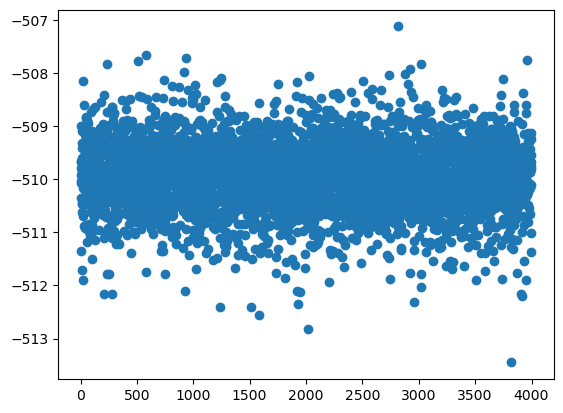

In [ ]:
N = 1000
key, subkey = jrn.split(key)
samples, lw = pgssm_importance_sampling(y, model, proposal.z, proposal.Omega, N, subkey)
plt.scatter(jnp.arange(4 * N), lw)
plt.show()

Weights should be calculated on the log scale, but we need them on the usual scale to use for Monte-Carlo integration. These are called **auto-normalised weights** and defined by $W(X^i) = \frac{w(X^i)}{\sum_{i = 1}^N w(X^i)}$.

As weights are only known up to a constant, we make exponentiation numerically stable by substracting (on the log-scale) the largest weight, ensuring that $\log w^i \leq 0$ for all weights and so $\sum_{i = 1}^N w^i \leq N$. 

In [ ]:
# | export
from jaxtyping import Float, Array


def normalize_weights(
    log_weights: Float[Array, "N"]  # log importance sampling weights
) -> Float[Array, "N"]:  # normalized importance sampling weights
    """Normalize importance sampling weights."""
    max_weight = jnp.max(log_weights)

    log_weights_corrected = log_weights - max_weight

    weights = jnp.exp(log_weights_corrected)

    return weights / weights.sum()

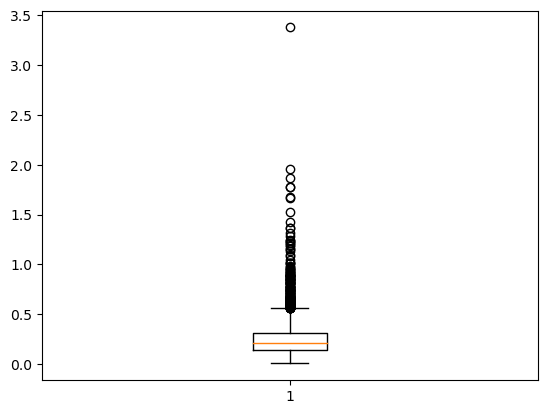

In [ ]:
weights = normalize_weights(lw)
plt.boxplot(weights[None] * N)
plt.show()

## Effective Sample Size

The effective sample size is an important diagnostic for the performance of importance sampling, it is defined by

$$
\text{ESS} = \frac{\left(\sum_{i = 1}^{N} w(X^i)\right)^2}{\sum_{i = 1}^N w^2(X_i)} = \frac{1}{\sum_{i = 1}^N W^2(X^i)}
$$

To compare different approximations one may also be interested in $\frac{\text{ESS}}{N} \cdot 100\%$, the percentage of effective samples.

In [ ]:
# | export
from jaxtyping import Float, Array


def ess(
    normalized_weights: Float[Array, "N"]  # normalized weights
) -> Float:  # the effective sample size
    """Compute the effective sample size of a set of normalized weights"""
    return 1 / (normalized_weights**2).sum()


def ess_lw(
    log_weights: Float[Array, "N"]  # the log weights
) -> Float:  # the effective sample size
    """Compute the effective sample size of a set of log weights"""
    return ess(normalize_weights(log_weights))


def ess_pct(
    log_weights: Float[Array, "N"]  # log weights
) -> Float:  # the effective sample size in percent, also called efficiency factor
    (N,) = log_weights.shape
    return ess_lw(log_weights) / N * 100

In [ ]:
ess(weights), ess_pct(lw)

(Array(2632.06893794, dtype=float64), Array(65.80172345, dtype=float64))

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()